In [ ]:
import os
import random
import sys
from contextlib import contextmanager
from functools import partial

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from tqdm import tqdm

from core.api_queries import (
    Entsoe,
    OpenMeteo,
    get_city_geocoding,
)
from core.controller import EconomicMPC, GreenHouseModel, GreenhouseSimulator
from core.generator import (
    gen_step,
)
from core.greenhouse_model import GreenHouse, x_init, x_init_dict
from core.plot import plot_response, plot_states, set_size
from core.simulate import simulate

load_dotenv()


@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


# For reproducibility
random.seed(40)

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "CMU Serif",
        "font.serif": "CMU Serif",
        "axes.grid": True,
    }
)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

In [ ]:
dt = 120

gh_model = GreenHouse(dt=dt)

cultivated_area = gh_model.A_c
lettuce_price = 0.0054  # EUR/g
N = 30  # number of control intervals

In [ ]:
# Paths
filepath = "examples/"
start_date = pd.Timestamp(2024, 10, 11, 14, 11)
# start_date = pd.Timestamp.now()
end_date = start_date + pd.Timedelta(days=15)
date_tag = f"{start_date.strftime("%Y-%m-%d")}_{(start_date + pd.Timedelta(days=15)).strftime("%Y-%m-%d")}-{dt}s"

In [ ]:
x0 = x_init.copy()

u_min = [0.0] * len(gh_model.active_actuators)
u_max = [100.0] * len(gh_model.active_actuators)

y_legend = ["Structural", "Non-Structural"]
u_legend = [*gh_model.active_actuators.keys()]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

ylabel = "Dry Weight (g/m$^2$)"
xlabel = "Time"
ulabel = "Actuation (\\%)"

# Get Weather Data

In [ ]:
filename = f"{filepath}data/weather-{date_tag}.csv"

if os.path.exists(filename):
    climate = pd.read_csv(filename, index_col=0, parse_dates=True)
else:
    openmeteo = OpenMeteo(
        latitude=52.52,  # Latitude of the location in degrees
        longitude=13.41,  # Longitude of the location in degrees
        altitude=157,
        tilt=[
            90,
            40,
            90,
            40,
            90,
            40,
            90,
            40,
        ],  # Tilt angle of the surface in degrees
        azimuth=[
            "NE",
            "NE",
            "SE",
            "SE",
            "SW",
            "SW",
            "NW",
            "NW",
        ],  # Azimuth angle of the surface in degrees (South facing)
        frequency="minutely_15",  # Frequency of the data
    )

    (
        city,
        country,
        country_code,
        tz,
        latitude,
        longitude,
        altitude,
    ) = get_city_geocoding("Bratislava")
    climate = (
        openmeteo.get_weather_data(
            start_date=start_date,
            end_date=end_date,
        )
        .tz_localize(tz, ambiguous=True)
        .asfreq(f"{dt}s")
        .interpolate(method="time")
    )
    entsoe = Entsoe()
    energy_cost = entsoe.get_electricity_price(
        country_code=country_code,
        start_date=start_date.tz_localize(tz),
        end_date=end_date.tz_localize(tz),
        tz=tz,
    )
    climate["energy_cost"] = (
        pd.concat([pd.Series(index=climate.index), energy_cost])
        .sort_index()
        .interpolate(method="time", limit_direction="both")
    )
    climate.to_csv(filename)

In [ ]:
# Plotting the DataFrame
ax = climate.plot()

# Placing the legend above the plot
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=3)

# Displaying the plot
plt.show()

## Explore responses to steps in individual inputs

In [ ]:
# [donotremove]
ncols = len(u_max) + 2
fig, axs = plt.subplots(
    nrows=2,
    ncols=ncols,
    sharex=True,
    sharey="row",
    figsize=set_size(width="ieee_full", subplots=(2, ncols)),
)
greenhouse_model = partial(gh_model.model, climate=climate.values)
_greenhouse_model = partial(gh_model._model, climate=climate.values)

sim_time_ = 86400 // dt
timestamps = pd.date_range(
    start=start_date, periods=sim_time_, freq=pd.Timedelta(seconds=dt)
)

for u_idx in range(ncols):
    u_min_ = u_min.copy()
    u_max_ = u_min.copy()
    if len(u_max) > u_idx:
        u_max_[u_idx] = u_max[u_idx]
    if len(u_max) < u_idx:
        u_min_ = u_max.copy()
        u_max_ = u_max.copy()
    u = partial(gen_step, u_min=u_min_, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        greenhouse_model,
        u=u,  # type: ignore
        sim_time=sim_time_,
        t_s=dt,
        x0=x0,  # type: ignore
    )
    plot_response(
        timestamps,
        y_out[:, -2:],
        u_out,
        axs_=axs[:, u_idx],
        y_legend=y_legend if u_idx == 0 else None,
        u_legend=u_legend if u_idx == 0 else None,
    )

    xs = []
    for i, (x, u) in enumerate(zip(y_out, u_out)):
        _, x_ = _greenhouse_model(i * dt, tuple(x), tuple(u))
        xs.append(x_)
    df = pd.DataFrame(xs, index=timestamps).select_dtypes(include=["float"])

    if u_idx == 0:
        # Plot response
        fig_states, axs_states = plt.subplots(
            nrows=len(df.columns),
            ncols=ncols,
            figsize=set_size(
                width="ieee_full", subplots=(len(df.columns), ncols)
            ),
            sharex=True,
            sharey="row",
        )

    plot_states(df, axs_states[:, u_idx], set_ylabel=(u_idx == 0))

axs[0, 0].set_ylabel(ylabel.replace(" (", "\n("))
axs[1, 0].set_xlabel(xlabel)
axs[1, 0].set_ylabel(ulabel.replace(" (", "\n("))

xformatter = mdates.DateFormatter("%H:%M")

for ax in axs[-1, :]:
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.tick_params(axis="x", rotation=20)
    ax.xaxis.set_major_formatter(xformatter)

for ax in axs_states[-1, :]:
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.tick_params(axis="x", rotation=20)
    ax.xaxis.set_major_formatter(xformatter)


lines_labels = [ax.get_legend_handles_labels() for ax in axs[0, :]]
lines, labels = (sum(lol, []) for lol in zip(*lines_labels))
fig.legend(
    lines,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=len(y_legend),
)
lines_labels = [ax.get_legend_handles_labels() for ax in axs[1, :]]
lines, labels = (sum(lol, []) for lol in zip(*lines_labels))
fig.legend(lines, labels, loc="lower center", ncol=len(u_legend))
fig.align_labels(axs[:, 0])
fig.tight_layout(pad=0.1)
fig.savefig(f"{filepath}results/step_response-outputs-{date_tag}.pdf")

fig_states.align_ylabels(axs_states[:, 0])
fig_states.tight_layout()
fig_states.savefig(f"{filepath}results/step_response-states-{date_tag}.pdf")

In [ ]:
# === Model ===================================================================
# Create a model instance
model = GreenHouseModel(gh_model, climate_vars=climate.columns)

# Find feasible initial state
x0 = x_init.copy()
u0 = np.array([0.0] * len(gh_model.active_actuators))
tvp0 = tuple(climate.values[0])
x0 = model.init_states(x0, u0, tvp0)

# === Simulator ===============================================================
simulator = GreenhouseSimulator(model, climate)

# === Runtime =================================================================
sim_steps = len(climate)


u0 = np.array(u0, ndmin=2).T
simulator.x0 = x0
simulator.set_initial_guess()

# Run the MPC simulation
U = pd.DataFrame(
    columns=[
        act for act, active in gh_model.active_actuators.items() if active == 1
    ],
    index=range(sim_steps),
)
X = pd.DataFrame(columns=[*x_init_dict.keys()], index=range(sim_steps))
for step in tqdm(range(sim_steps)):
    with suppress_stdout():
        U.iloc[step] = u0[:, 0]
        x0 = simulator.make_step(u0)
        if np.isnan(x0).any():
            raise ValueError("x0 contains NaN values.")
        X.iloc[step] = x0[:, 0]

timestamps = pd.date_range(
    start=start_date, periods=sim_steps, freq=pd.Timedelta(seconds=dt)
)

In [ ]:
profit_costs = model.analyze_profit_and_costs(
    x0[:, 0] - x_init, U, climate["energy_cost"].values[:sim_steps]
)
profit_costs.to_csv(
    f"{filepath}results/profit_costs-u_{int(u0[0][0])}-N_{N}-steps_{sim_steps}.csv"
)

In [ ]:
print(
    f"Congrats, your greenhouse generated profit of {profit_costs['Total']:.2f} EUR! 🤑"
)

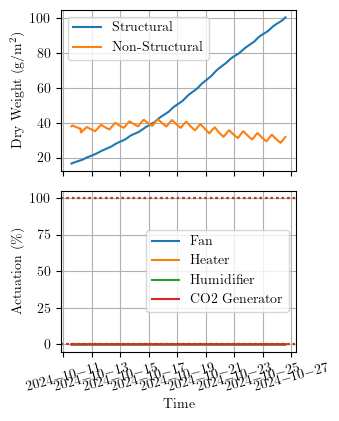

In [ ]:
# [donotremove]

axs = plot_response(
    timestamps,
    X.iloc[:, -2:],
    U,
    u_min=u_min,
    u_max=u_max,
    y_legend=["Structural", "Non-Structural"],
    u_legend=[*gh_model.active_actuators.keys()],
    y_label=ylabel,
    u_label=ulabel,
    t_label=xlabel,
)

fig = axs[0].get_figure()
fig.savefig(
    f"{filepath}results/gh_sim-u_{int(u0[0][0])}-N_{N}-steps_{sim_steps}.pdf"
)

# Control Scenario

In [ ]:
# === Model ===================================================================
model = GreenHouseModel(gh_model, climate_vars=climate.columns)

# Find feasible initial state
x0 = x_init.copy()
u0 = np.array([0.0] * len(gh_model.active_actuators))
tvp0 = tuple(climate.values[0])
x0 = model.init_states(x0, u0, tvp0)

# === Control =================================================================
mpc = EconomicMPC(
    model,
    climate,
    N,
    u_min=u_min,
    u_max=u_max,
)

# === Simulator ===============================================================
simulator = GreenhouseSimulator(model, climate)

# === Runtime =================================================================
sim_steps = len(climate)  # [1/dt]

mpc.x0 = x0
mpc.u0 = np.array([0.0] * model.n_u)
simulator.x0 = x0
mpc.set_initial_guess()
simulator.set_initial_guess()

# Run the MPC simulation
U = pd.DataFrame(
    columns=[
        act for act, active in gh_model.active_actuators.items() if active == 1
    ],
    index=range(sim_steps),
)
X = pd.DataFrame(columns=[*x_init_dict.keys()], index=range(sim_steps))

for step in tqdm(range(sim_steps)):
    if step * dt + N + 1 > len(climate):
        if step + N == len(climate):
            break

    with suppress_stdout():
        u0 = mpc.make_step(x0)
        U.iloc[step] = u0[:, 0]
        x0 = simulator.make_step(u0)
        if np.isnan(x0).any():
            raise ValueError("x0 contains NaN values.")
        X.iloc[step] = x0[:, 0]

timestamps = pd.date_range(
    start=start_date, periods=sim_steps, freq=pd.Timedelta(seconds=dt)
)

In [ ]:
profit_costs = model.analyze_profit_and_costs(
    x0.flatten() - x_init, U, climate["energy_cost"].values[:sim_steps]
)
profit_costs.to_csv(
    f"{filepath}results/profit_costs-mpc_co2-N_{N}-steps_{sim_steps}.csv"
)

In [ ]:
profit_costs

In [ ]:
print(
    f"Congrats, your greenhouse generated profit of {profit_costs['Total']:.2f} EUR! 🤑"
)

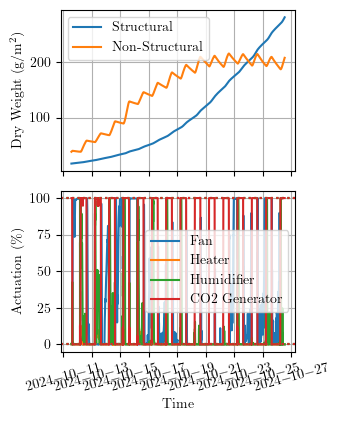

In [ ]:
# [donotremove]

axs = plot_response(
    timestamps,
    X.iloc[:, -2:],
    U,
    u_min=u_min,
    u_max=u_max,
    y_legend=["Structural", "Non-Structural"],
    u_legend=[*gh_model.active_actuators.keys()],
    y_label=ylabel,
    u_label=ulabel,
    t_label=xlabel,
)

fig = axs[0].get_figure()
fig.savefig(
    f"{filepath}results/greenhouse_control-mpc_co2-N_{N}-steps_{sim_steps}.pdf"
)

# Control Scenario - no co2 care

In [ ]:
# === Model ===================================================================
model = GreenHouseModel(gh_model, climate_vars=climate.columns)

# Find feasible initial state
x0 = x_init.copy()
u0 = np.array([0.0] * len(gh_model.active_actuators))
tvp0 = tuple(climate.values[0])
x0 = model.init_states(x0, u0, tvp0)

# === Control =================================================================
mpc = EconomicMPC(
    model,
    climate,
    N,
    u_min=u_min,
    u_max=u_max,
    co2_we_care=False,
)

# === Simulator ===============================================================
simulator = GreenhouseSimulator(model, climate)


# === Runtime =================================================================
sim_steps = len(climate)  # [1/dt]

mpc.x0 = x0
mpc.u0 = np.array([0.0] * model.n_u)
simulator.x0 = x0
mpc.set_initial_guess()
simulator.set_initial_guess()

# Run the MPC simulation
U = pd.DataFrame(
    columns=[
        act for act, active in gh_model.active_actuators.items() if active == 1
    ],
    index=range(sim_steps),
)
X = pd.DataFrame(columns=[*x_init_dict.keys()], index=range(sim_steps))
for step in tqdm(range(sim_steps)):
    if step * dt + N + 1 > len(climate):
        if step + N == len(climate):
            break

    with suppress_stdout():
        u0 = mpc.make_step(x0)
        U.iloc[step] = u0[:, 0]
        x0 = simulator.make_step(u0)
        if np.isnan(x0).any():
            raise ValueError("x0 contains NaN values.")
        X.iloc[step] = x0[:, 0]

timestamps = pd.date_range(
    start=start_date, periods=sim_steps, freq=pd.Timedelta(seconds=dt)
)

In [ ]:
profit_costs = model.analyze_profit_and_costs(
    x0[-2:], U, climate["energy_cost"].values[:sim_steps]
)
profit_costs.to_csv(
    f"{filepath}results/profit_costs-mpc_profit-N_{N}-steps_{sim_steps}.csv"
)

In [ ]:
profit_costs

In [ ]:
print(
    f"Congrats, your greenhouse generated profit of {profit_costs['Total'].sum():.2f} EUR! 🤑"
)

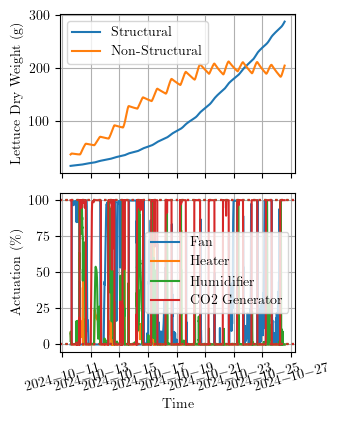

In [ ]:
# [donotremove]

axs = plot_response(
    timestamps,
    X.iloc[:, -2:],
    U,
    u_min=u_min,
    u_max=u_max,
    y_legend=["Structural", "Non-Structural"],
    u_legend=[*gh_model.active_actuators.keys()],
    y_label="Lettuce Dry Weight (g)",
    u_label="Actuation (\\%)",
    t_label="Time",
)

fig = axs[0].get_figure()
fig.savefig(
    f"{filepath}results/greenhouse_control-mpc_profit-N_{N}-steps_{sim_steps}.pdf"
)

## Linear MPC

In [ ]:
from do_mpc.model import linearize

# === Model ===================================================================
model = GreenHouseModel(gh_model, climate_vars=climate.columns)
# Find feasible initial state
x0 = x_init.copy()
u0 = np.array([0.0] * len(gh_model.active_actuators))
tvp0 = tuple(climate.values[0])
x0 = model.init_states(x0, u0, tvp0)

linmodel = linearize(model, x0, u0, np.insert(climate.iloc[0].values, 0, 0))
linmodel.lettuce_price = model.lettuce_price
linmodel.gh = model.gh
linmodel.dt = model.dt

# === Control =================================================================
mpc = EconomicMPC(
    linmodel,
    climate,
    N,
    u_min=u_min,
    u_max=u_max,
)

# === Simulator ===============================================================
simulator = GreenhouseSimulator(model, climate)

# === Runtime =================================================================
sim_steps = len(climate)  # [1/dt]

mpc.x0 = x0
mpc.u0 = np.array([0.0] * model.n_u)
simulator.x0 = x0
mpc.set_initial_guess()
simulator.set_initial_guess()

# Run the MPC simulation
U = pd.DataFrame(
    columns=[
        act for act, active in gh_model.active_actuators.items() if active == 1
    ],
    index=range(sim_steps),
)
X = pd.DataFrame(columns=[*x_init_dict.keys()], index=range(sim_steps))
for step in tqdm(range(sim_steps)):
    if step * dt + N + 1 > len(climate):
        if step + N == len(climate):
            break

    with suppress_stdout():
        u0 = mpc.make_step(x0)
        U.iloc[step] = u0[:, 0]
        x0 = simulator.make_step(u0)
        if np.isnan(x0).any():
            raise ValueError("x0 contains NaN values.")
        X.iloc[step] = x0[:, 0]

    linmodel = linearize(
        model, x0, u0, np.insert(climate.iloc[step].values, 0, step)
    )
    linmodel.lettuce_price = model.lettuce_price
    linmodel.gh = model.gh
    linmodel.dt = model.dt
    mpc.model = linmodel

timestamps = pd.date_range(
    start=start_date, periods=sim_steps, freq=pd.Timedelta(seconds=dt)
)

In [ ]:
profit_costs = model.analyze_profit_and_costs(
    x0.flatten() - x_init, U, climate["energy_cost"].values[:sim_steps]
)
profit_costs.to_csv(
    f"{filepath}results/profit_costs-linmpc_co2-N_{N}-steps_{sim_steps}.csv"
)

In [ ]:
profit_costs

In [ ]:
print(
    f"Congrats, your greenhouse generated profit of {profit_costs['Total']:.2f} EUR! 🤑"
)

In [ ]:
# [donotremove]

axs = plot_response(
    timestamps,
    X.iloc[:, -2:],
    U,
    u_min=u_min,
    u_max=u_max,
    y_legend=["Structural", "Non-Structural"],
    u_legend=[*gh_model.active_actuators.keys()],
    y_label=ylabel,
    u_label=ulabel,
    t_label=xlabel,
)

fig = axs[0].get_figure()
fig.savefig(
    f"{filepath}results/greenhouse_control-linmpc_co2-N_{N}-steps_{sim_steps}.pdf"
)